In [180]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd

msa_file = '../urban_greening/msa/michiganMSA_reprojected.shp'
gpp_file = "../urban_greening/nov.15/michigan_test/modis-250-gpp-2015001.tif"
outRas = 'test1.tif'
nlcd_file = "../urban_greening/nov.15/nlcd_2016_land_cover_l48_20210604.img"
ua_file = "../urban_greening/gis_processed/ua/ua_30.tif"


msa=gpd.read_file(msa_file)
msa=msa[msa['NAMELSAD']=='Grand Rapids-Wyoming-Kentwood, MI Metro Area'] # Subsetting to my AOI

with rasterio.open(gpp_file) as gpp_dstrd:
    Vector=msa.to_crs(gpp_dstrd.crs)
    msa_crs = Vector.crs
    gpp_crs = gpp_dstrd.crs
    gpp_clip_image, gpp_clip_transform=mask(gpp_dstrd,Vector.geometry,crop=True)
    

    # replace fillvalue 65535 with np.nan
    gpp_clip_image = np.where(gpp_clip_image == 65535, np.nan, gpp_clip_image) 

    gpp_msa = gpp_clip_image[:][:][0]

    from shapely.geometry import mapping
    geometries = [mapping(geom) for geom in msa.geometry]

    with rasterio.open(nlcd_file) as nlcd_dstrd:
        nlcd_crs = nlcd_dstrd.crs
        
        msa_crsr = msa.to_crs(nlcd_crs)
        
        
        
        # Clip the raster using the reprojected geometries
        nlcd_clip_image, nlcd_clip_transform = mask(nlcd_dstrd, geometries, crop=True)
        nlcd_msa = nlcd_clip_image[:][:][0]

        

        import numpy as np
        gpp_msa_rr = np.empty((nlcd_clip_image.shape[1], nlcd_clip_image.shape[2]), dtype=np.float32) #make it support nan
        # gpp_msa_rr = np.empty((nlcd_clip_image.shape[1], nlcd_clip_image.shape[2]), dtype=gpp_dstrd.meta['dtype']), 
        from rasterio.enums import Resampling
        from rasterio.warp import calculate_default_transform, reproject
        reproject(
            source=gpp_msa,
            destination=gpp_msa_rr,
            src_transform=gpp_clip_transform,
            src_crs=gpp_crs,
            dst_transform=nlcd_clip_transform,
            dst_crs=nlcd_crs,
            resampling=Resampling.nearest, # use nearest to prevent unreasonable upscaling
            src_nodata=np.nan
        )
        
       

        with rasterio.open(ua_file) as ua_dstrd:
            ua_crs = ua_dstrd.crs

            ua_clip_image, ua_clip_transform = mask(ua_dstrd, geometries, crop=True)
            ua_msa = ua_clip_image[:][:][0]

            import numpy as np
            ua_msa_rr = np.empty((ua_clip_image.shape[1], ua_clip_image.shape[2]), dtype=ua_dstrd.meta['dtype'])

            from rasterio.enums import Resampling
            from rasterio.warp import calculate_default_transform, reproject
            reproject(
                source=ua_msa,
                destination=ua_msa_rr,
                src_transform=ua_clip_transform,
                src_crs=ua_crs,
                dst_transform=nlcd_clip_transform,
                dst_crs=nlcd_crs,
                resampling=Resampling.nearest
            )

In [190]:
nlcd_clip_image.shape

(1, 4081, 4001)

In [179]:
# Metadata for the output TIFF
output_path = "gpp_msa_rr_beforefillnearestfloatwithnan.tif"

# Write the ndarray to a GeoTIFF
with rasterio.open(
    output_path,
    "w",
    driver="GTiff",
    height=gpp_msa_rr.shape[0],
    width=gpp_msa_rr.shape[1],
    count=1,  # Number of bands
    dtype=gpp_msa_rr.dtype,
    crs=nlcd_crs,
    transform=nlcd_clip_transform,
    # nodata=np.nan, # do not set this or there will be reprojet edge with value 0
) as dst:
    # Write data to the first band
    dst.write(gpp_msa_rr, 1)

print(f"GeoTIFF saved to {output_path}")

CPLE_AppDefinedError: Deleting gpp_msa_rr_beforefillnearestfloatwithnan.tif failed: Permission denied

In [183]:
np.unique(gpp_msa_rr == np.nan, return_counts=True)

(array([False]), array([16328081]))

In [172]:
rasterio.plot.show(output_raster)

AttributeError: 'dict' object has no attribute 'ndim'

In [34]:
np.unique(gpp_clip_image)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       27., 29., 30., 31., nan])

In [3]:
from rasterio import plot

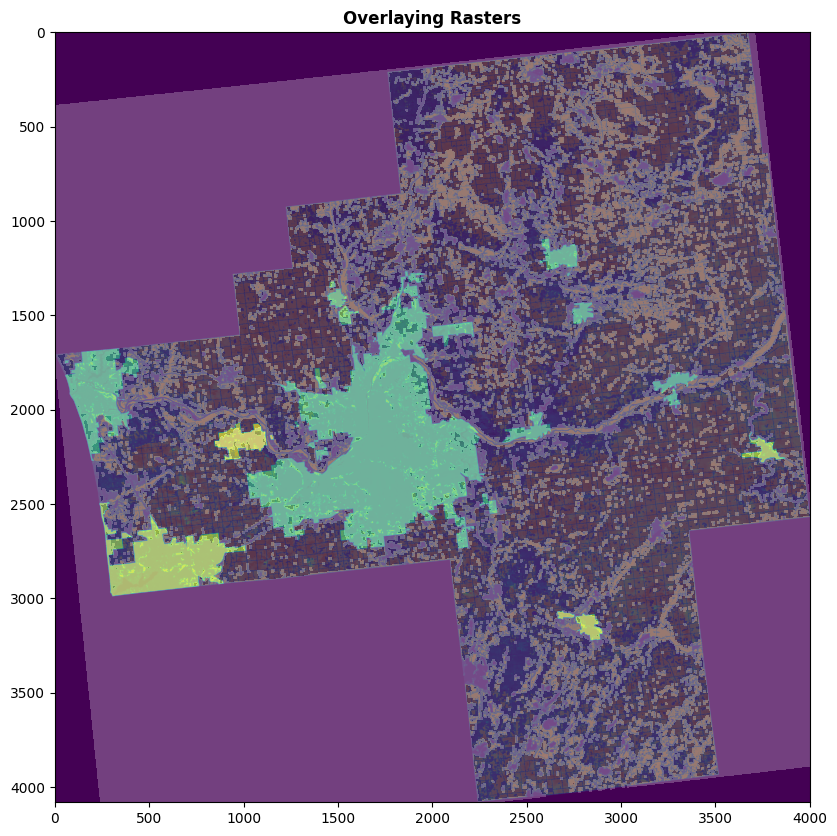

In [78]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
# Show the first raster
rasterio.plot.show(gpp_msa_rr, ax=ax, title="Overlaying Rasters")

# Show the second raster as an overlay
rasterio.plot.show(nlcd_msa, ax=ax, alpha=0.5)  # Adjust alpha for transparency

rasterio.plot.show(ua_msa_rr, ax=ax, alpha=0.5)  # Adjust alpha for transparency

# Show the plot
plt.show()

In [134]:
np.unique(gpp_msa_rr)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       27., 29., 30., 31., nan], dtype=float32)

In [98]:
valid_gpp_mask = (gpp_msa_rr != np.nan)
urban_mask = (ua_msa_rr != 0)
suburban_mask = (ua_msa_rr == 0)
forest_mask = (nlcd_msa == 41) | (nlcd_msa == 42) | (nlcd_msa == 43)
shrub_mask = (nlcd_msa == 51) | (nlcd_msa == 52)
grass_mask = (nlcd_msa > 70) & (nlcd_msa < 90)
wetland_mask = (nlcd_msa >= 90) & (nlcd_msa < 100)

# TODO: urban developed, and set to 0 for mean_gpp
nlcd_mask_dict = {
    'urban_forest': urban_mask & forest_mask,
    'suburban_forest': suburban_mask & forest_mask,
    'urban_shrub': urban_mask & shrub_mask,
    'suburban_shrub': suburban_mask & shrub_mask,
    'urban_grass': urban_mask & grass_mask,
    'suburban_grass': suburban_mask & grass_mask,
    'urban_wetland': urban_mask & wetland_mask,
    'suburban_wetland': suburban_mask & wetland_mask,
}

In [144]:
np.unique(gpp_msa_rr[valid_gpp_mask])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       27., 29., 30., 31., nan], dtype=float32)

In [142]:

np.unique(gpp_msa_rr, return_counts=True)


(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        27., 29., 30., 31., nan], dtype=float32),
 array([2082934,  895191, 1090064, 1147917, 1127791,  949269,  622648,
         378007,  187006,   89382,   44263,   20034,   11051,    6446,
           3053,    1882,    1417,     695,    1091,     866,     432,
            485,     345,     260,     219,      85,     259,      42,
             44,      44, 7664859]))

In [99]:
print("urban", np.unique(urban_mask, return_counts=True))

print("forest", np.unique(forest_mask, return_counts=True))

print("urban forest", np.unique(urban_mask & forest_mask, return_counts=True))

print("urban forest with valid gpp", np.unique(valid_gpp_mask & urban_mask & forest_mask, return_counts=True))

urban (array([False,  True]), array([15116192,  1211889]))
forest (array([False,  True]), array([14427845,  1900236]))
urban forest (array([False,  True]), array([16182408,   145673]))
urban forest with valid gpp (array([False,  True]), array([16182408,   145673]))


In [100]:
unique_values, counts = np.unique(gpp_msa_rr.flatten(), return_counts=True)
value_counts = dict(zip(unique_values, counts))

# Print the result
print("Value counts:", value_counts)

Value counts: {np.float32(0.0): np.int64(2082934), np.float32(1.0): np.int64(895191), np.float32(2.0): np.int64(1090064), np.float32(3.0): np.int64(1147917), np.float32(4.0): np.int64(1127791), np.float32(5.0): np.int64(949269), np.float32(6.0): np.int64(622648), np.float32(7.0): np.int64(378007), np.float32(8.0): np.int64(187006), np.float32(9.0): np.int64(89382), np.float32(10.0): np.int64(44263), np.float32(11.0): np.int64(20034), np.float32(12.0): np.int64(11051), np.float32(13.0): np.int64(6446), np.float32(14.0): np.int64(3053), np.float32(15.0): np.int64(1882), np.float32(16.0): np.int64(1417), np.float32(17.0): np.int64(695), np.float32(18.0): np.int64(1091), np.float32(19.0): np.int64(866), np.float32(20.0): np.int64(432), np.float32(21.0): np.int64(485), np.float32(22.0): np.int64(345), np.float32(23.0): np.int64(260), np.float32(24.0): np.int64(219), np.float32(25.0): np.int64(85), np.float32(27.0): np.int64(259), np.float32(29.0): np.int64(42), np.float32(30.0): np.int64(44

In [101]:
ave_1 = np.nanmean(gpp_msa_rr[valid_gpp_mask])
ave_1

np.float32(2.947013)

In [ ]:
# urban_forest_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['urban_forest'], gpp_msa_rr, np.nan)
# suburban_forest_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['suburban_forest'], gpp_msa_rr, np.nan)
# urban_shrub_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['urban_shrub'], gpp_msa_rr, np.nan)
# suburban_shrub_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['suburban_shrub'], gpp_msa_rr, np.nan)
# urban_grass_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['urban_grass'], gpp_msa_rr, np.nan)
# suburban_grass_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['suburban_grass'], gpp_msa_rr, np.nan)
# urban_wetland_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['urban_wetland'], gpp_msa_rr, np.nan)
# suburban_wetland_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['suburban_wetland'], gpp_msa_rr, np.nan)

# filtered_gpp_dict = {
#     'urban_forest': urban_forest_filtered_gpp,
#     'suburban_forest': suburban_forest_filtered_gpp,
#     'urban_shrub': urban_shrub_filtered_gpp,
#     'suburban_shrub': suburban_shrub_filtered_gpp,
#     'urban_grass': urban_grass_filtered_gpp,
#     'suburban_grass': suburban_grass_filtered_gpp,
#     'urban_wetland': urban_wetland_filtered_gpp,
#     'suburban_wetland': suburban_wetland_filtered_gpp
# }

# np.unique(urban_forest_filtered_gpp)

In [110]:
from rasterio.features import geometry_mask
import rasterstats

gpp_msa_rr_filled = np.copy(gpp_msa_rr)

category_gpp_mean_list = []
record = {'name': 'test_msa'}

water_mask = (nlcd_msa > 10) & (nlcd_msa < 20)
developed_mask = (nlcd_msa > 20) & (nlcd_msa < 30)

# gpp_msa_rr_filled[~valid_gpp_mask & water_mask] = 0
# gpp_msa_rr_filled[~valid_gpp_mask & developed_mask] = 0
gpp_msa_rr_filled[water_mask] = 0
gpp_msa_rr_filled[developed_mask] = 0
                  
for category, landcover_mask in nlcd_mask_dict.items():

    category_gpp_mean = np.nanmean(gpp_msa_rr[landcover_mask])
    record[category] = category_gpp_mean
    
    gpp_msa_rr_filled[~valid_gpp_mask & landcover_mask] = category_gpp_mean

print(record)

{'name': 'test_msa', 'urban_forest': np.float32(3.259661), 'suburban_forest': np.float32(3.4994838), 'urban_shrub': np.float32(2.8415134), 'suburban_shrub': np.float32(3.856921), 'urban_grass': np.float32(3.4969804), 'suburban_grass': np.float32(3.6307428), 'urban_wetland': np.float32(3.2366927), 'suburban_wetland': np.float32(3.4754617)}


In [154]:
landcover_mask = nlcd_mask_dict['urban_forest']
combined_mask = valid_gpp_mask & landcover_mask
print("test", np.unique(combined_mask, return_counts=True))

test (array([False,  True]), array([16182408,   145673]))


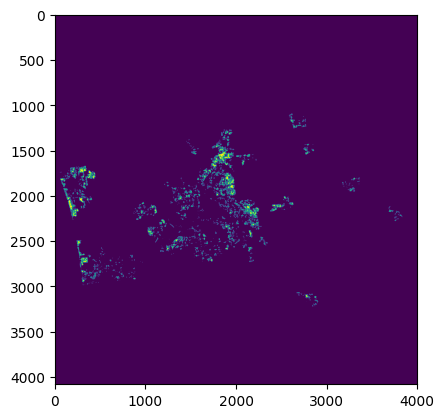

<Axes: >

In [156]:

rasterio.plot.show(landcover_mask)


In [148]:
np.unique(valid_gpp_mask & landcover_mask, return_counts=True)

(array([False,  True]), array([16326700,     1381]))

In [120]:
nlcd_mask_dict['urban_forest']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [116]:

np.nanmean(gpp_msa_rr[])

np.float32(3.259661)

In [112]:
gpp_msa_rr_filled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [111]:
np.unique(gpp_msa_rr_filled)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       27., 29., 30., 31., nan], dtype=float32)

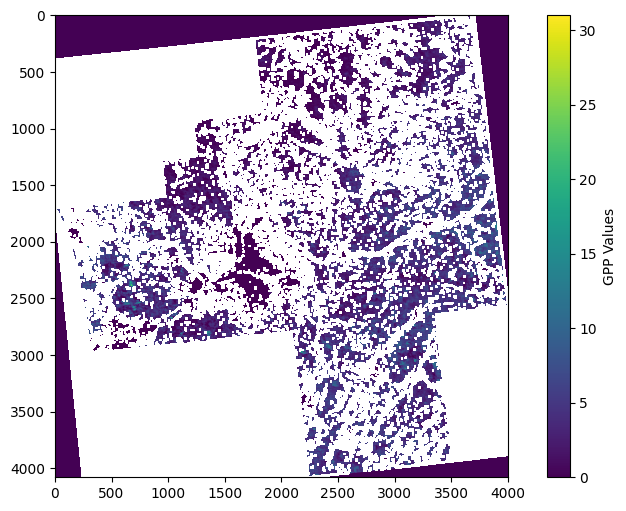

In [ ]:
# rasterio.plot.show(gpp_msa_rr_filled)

fig, ax = plt.subplots(figsize=(10, 6)) 
cax = ax.imshow(gpp_msa_rr_filled, cmap='viridis')  # Use a colormap of your choice
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label("GPP Values")
plt.show()

In [107]:
# Metadata for the output TIFF
output_path = "gppnanfilled.tif"

# Write the ndarray to a GeoTIFF
with rasterio.open(
    output_path,
    "w",
    driver="GTiff",
    height=gpp_msa_rr_filled.shape[0],
    width=gpp_msa_rr_filled.shape[1],
    count=1,  # Number of bands
    dtype=gpp_msa_rr_filled.dtype,
    crs=nlcd_crs,
    transform=nlcd_clip_transform,
    nodata=np.nan,
) as dst:
    # Write data to the first band
    dst.write(gpp_msa_rr_filled, 1)

print(f"GeoTIFF saved to {output_path}")

GeoTIFF saved to gppnanfilled.tif


## nee

In [206]:
nc_ds.attrs

{'Comment': 'Ensemble median of 9 members',
 'Version': 'v1',
 'TYPE': 'ensemble',
 'SETUP': 'RS',
 'Temporal_Resolution_tRESO': 'monthly',
 'Reference': 'Jung et al. 2020 [https://doi.org/10.5194/bg-2019-368], Tramontana et al. 2016 [doi:10.5194/bg-13-4291-2016]',
 'Institution': 'MPI-BGC-BGI',
 'Provided_By': 'Martin Jung [mjung@bgc-jena.mpg.de] on behalf of FLUXCOM team',
 'Created_By': 'Fabian Gans [fgans@bgc-jena.mpg.de], Ulrich Weber [uweber@bgc-jena.mpg.de]',
 'Aggregation_Method': 'first interpolate to daily,  second aggregate to monthly mean',
 'History': 'created: Wed Jan 15 17:31:17 2020',
 'Meteorolgical_Data_METEO': 'NONE',
 'Flux_Partitioning_FP': 'NONE',
 'Machine_Learning_Method_MLM': 'MTEM,GMDH_CV,MTEV,MTE,KRR,MARS,SVM,ANN,RF',
 'Spatial_Resolution_sRESO': '4320_2160',
 'Temporal_Aggregation_Method': 'first interpolate to daily,  second aggregate to monthly mean'}

In [159]:
import netCDF4 as nc

nee_file = "../urban_greening/NEE.RS.FP-NONE.MLM-ALL.METEO-NONE.4320_2160.monthly.2015.nc"
ds = nc.Dataset(nee_file)


In [275]:
data = ds['NEE'][:]

In [240]:
data.shape

(12, 2160, 4320)

In [ ]:
nee_month = data[0]

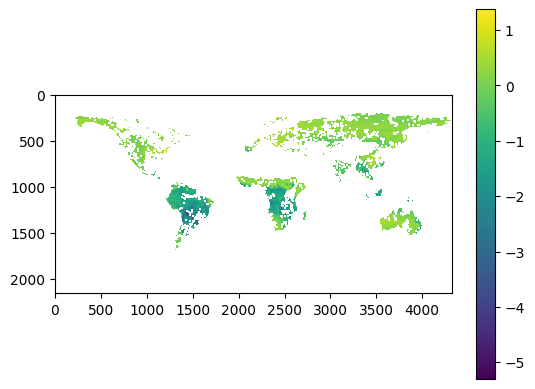

In [246]:
plt.imshow(nee_month)
plt.colorbar()

In [284]:
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
from shapely.geometry import mapping

nee_month_regular = np.ma.filled(nee_month, fill_value=np.nan)

clipped = nee_month_regular.rio.clip([mapping(msa.geometrt)], msa_crs, drop=True)
clipped

AttributeError: 'numpy.ndarray' object has no attribute 'rio'

In [278]:
nlcd_dstrd

<closed DatasetReader name='../urban_greening/nov.15/nlcd_2016_land_cover_l48_20210604.img' mode='r'>

In [277]:
nee_month

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999.0,
  dtype=float32)

In [247]:
nee_month

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999.0,
  dtype=float32)

In [255]:
# get crs and transform for nee

info = nee_file.split('/')[-1].split('.')
var_name = info[0]
ML_method = info[3]
year = info[7]
partitioning_method = info[2]

import xarray as xr
nee_ds = xr.open_dataset(nee_file)
# calc transform for this resolution, given the data is worldwide (the original metadata is incorrect)
minx, miny, maxx, maxy = -180.0, -90.0, 180.0, 90.0
resolution_x = 360 / int(nee_ds.attrs['Spatial_Resolution_sRESO'].split('_')[0])
resolution_y = 180 / int(nee_ds.attrs['Spatial_Resolution_sRESO'].split('_')[1])
nee_transform = rasterio.transform.from_origin(minx, maxy, resolution_x, resolution_y)

nee_crs = gpp_crs # assume it's same



In [ ]:
with rasterio.open(raster_path) as src:
    clipped_array, clipped_transform = mask(src, geometries, crop=True)




    with rasterio.open(gpp_file) as gpp_dstrd:
    Vector=msa.to_crs(gpp_dstrd.crs)
    msa_crs = Vector.crs
    gpp_crs = gpp_dstrd.crs
    gpp_clip_image, gpp_clip_transform=mask(gpp_dstrd,Vector.geometry,crop=True)

    gpp_msa = gpp_clip_image[:][:][0]
    
    

    from shapely.geometry import mapping
    geometries = [mapping(geom) for geom in msa.geometry]

    with rasterio.open(nlcd_file) as nlcd_dstrd:
        nlcd_crs = nlcd_dstrd.crs
        
        msa_crsr = msa.to_crs(nlcd_crs)

In [257]:
ds = xr.open_dataset(nee_file)

# Select a specific time slice
nee_month = ds.sel(time=ds.time[0])
nee_month

<xarray.Dataset> Size: 75MB
Dimensions:    (latitude: 2160, longitude: 4320)
Coordinates:
    time       datetime64[ns] 8B 2015-01-31T00:00:00.000040
  * latitude   (latitude) float64 17kB 89.96 89.87 89.79 ... -89.88 -89.96
  * longitude  (longitude) float64 35kB -180.0 -179.9 -179.8 ... 179.9 180.0
Data variables:
    NEE        (latitude, longitude) float32 37MB ...
    NEE_mad    (latitude, longitude) float32 37MB ...
Attributes: (12/16)
    Comment:                      Ensemble median of 9 members
    Version:                      v1
    TYPE:                         ensemble
    SETUP:                        RS
    Temporal_Resolution_tRESO:    monthly
    Reference:                    Jung et al. 2020 [https://doi.org/10.5194/b...
    ...                           ...
    History:                      created: Wed Jan 15 17:31:17 2020
    Meteorolgical_Data_METEO:     NONE
    Flux_Partitioning_FP:         NONE
    Machine_Learning_Method_MLM:  MTEM,GMDH_CV,MTEV,MTE,KRR,MARS,SVM,ANN,RF
    Spatial_Resolution_sRESO:     4320_2160
    Temporal_Aggregation_Method:  first interpolate to daily,  second aggrega...

In [258]:
lat = ds["latitude"]  # Replace with your latitude variable name
lon = ds["longitude"] 

<xarray.DataArray 'latitude' (latitude: 2160)> Size: 17kB
array([ 89.958333,  89.874999,  89.791666, ..., -89.791667, -89.875   ,
       -89.958333])
Coordinates:
  * latitude  (latitude) float64 17kB 89.96 89.87 89.79 ... -89.79 -89.88 -89.96 <xarray.DataArray 'longitude' (longitude: 4320)> Size: 35kB
array([-179.958333, -179.875   , -179.791667, ...,  179.791665,  179.874999,
        179.958332])
Coordinates:
  * longitude  (longitude) float64 35kB -180.0 -179.9 -179.8 ... 179.9 180.0


In [262]:
transform = rasterio.transform.from_bounds(lon.min(), lat.min(), lon.max(), lat.max(), len(lon), len(lat))

In [ ]:
mask = geometry_mask(
    [msa.geometry],
    transform=transform,
    invert=True,
    out_shape=(len(lat), len(lon))
)

C:\Users\qifanw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'FeatureCollection', 'features': [{'id': '6', 'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Polygon', 'coordinates': (((786115.2703000009, 2276194.1306), (786734.0045000017, 2276250.198999999), (787805.5251000002, 2276349.4155), (790688.6988000013, 2276609.226500001), (791108.8968999982, 2276644.6488000005), (791495.9611000009, 2276681.1680999994), (793517.9767000005, 2276881.567399999), (794483.5518999994, 2276970.2468999997), (794638.1460999995, 2276984.2963999994), (796258.2875000015, 2277133.6834999993), (797591.5115999989, 2277288.5666000005), (802636.9618000016, 2277883.2807), (805075.2653999999, 2278152.9838999994), (805097.4726000018, 2278155.8236999996), (805840.053199999, 2278235.5007000007), (806634.2179999985, 2278349.239600001), (811047.1433999985,

In [264]:
data_array = nee_month["NEE"]  # Replace with your variable name
masked_data = data_array.where(mask)

In [266]:
clipped_array = np.where(mask, data_array.values, np.nan)

In [271]:
np.nanmean(clipped_array)

C:\Users\qifanw\AppData\Local\Temp\1\ipykernel_18952\3670577467.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(clipped_array)


np.float32(nan)

In [268]:
clipped_array.shape

(2160, 4320)

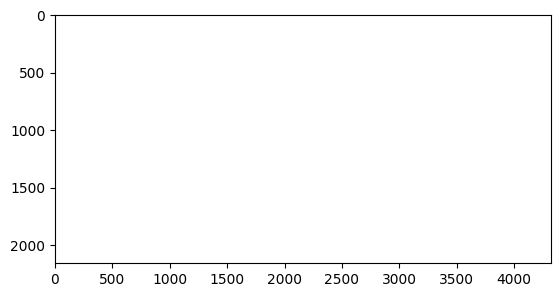

<Axes: >

In [270]:
rasterio.plot.show(clipped_array)

# fold

In [229]:
nee_file = "../urban_greening/NEE.RS.FP-NONE.MLM-ALL.METEO-NONE.4320_2160.monthly.2015.nc"

info = nee_file.split('/')[-1].split('.')
var_name = info[0]
ML_method = info[3]
year = info[7]
partitioning_method = info[2]

import xarray as xr
nee_ds = xr.open_dataset(nee_file)
# calc transform for this resolution, given the data is worldwide (the original metadata is incorrect)
minx, miny, maxx, maxy = -180.0, -90.0, 180.0, 90.0
resolution_x = 360 / int(nee_ds.attrs['Spatial_Resolution_sRESO'].split('_')[0])
resolution_y = 180 / int(nee_ds.attrs['Spatial_Resolution_sRESO'].split('_')[1])
nee_transform = rasterio.transform.from_origin(minx, maxy, resolution_x, resolution_y)

import rioxarray

nee_ds.rio.write_crs("epsg:4326", inplace=True)

nee_ds.rio.clip(msa.geometry.apply(mapping), msa_crs, drop=True)
# nee_crs = gpp_dstrd.crs # assume is epsg:4326, same as gpp
# from rasterio import features
# features.geometry_mask(msa, transform=nee_crs,
#                     invert=True,
#                     out_shape=(nee_ds.rio.height, nee_ds.rio.width))



# with rasterio.open(nee_file) as nee_dstrd:
#     nee_crs = gpp_dstrd.crs # assume is epsg:4326, same as gpp
#     print(nee_dstrd.meta)

#     nee_dstrd = nee_dstrd.write_crs(nee_dstrd)  # Attach CRS if missing
# # transform = ds.rio.transform() 

#     # NEE = nee_dstrd.read()

#     # nee_clip_image, nee_transform = mask(nee_dstrd,msa.geometry,crop=True)
    

    #     Vector=msa.to_crs(gpp_dstrd.crs)
    # msa_crs = Vector.crs
    # gpp_crs = gpp_dstrd.crs
    # gpp_clip_image, gpp_clip_transform=mask(gpp_dstrd,Vector.geometry,crop=True)

    # gpp_msa = gpp_clip_image[:][:][0]
    
    # print("CRS:", src.crs)

    # # Get the resolution
    # print("Resolution:", src.res)

    # # Optional: Inspect other metadata
    # print("Metadata:", src.meta)

NoDataInBounds: No data found in bounds. Data variable: NEE

In [214]:
nee_dstrd.read('NEE')

ValueError: Can't read closed raster file

In [211]:
import xarray as xr

nc_ds = xr.open_dataset(nee_file)
nee = nc_ds['NEE'][:]



nee['']

<closed DatasetReader name='../urban_greening/NEE.RS.FP-NONE.MLM-ALL.METEO-NONE.4320_2160.monthly.2015.nc' mode='r'>

In [ ]:

data = []
time =  nee.time[0]



nee_month = nc_var.sel(time=time)
nc_arr_vals = nc_arr.values

time_val = time.astype('datetime64[M]').astype(str)